In [1]:
import tensorflow as tf  
 
# Display the version
print(tf.__version__)    
 
# other imports
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout
from tensorflow.keras.layers import GlobalMaxPooling2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, Reshape, Add
from tensorflow.keras.layers import Layer, Softmax, ReLU, Permute, Activation
from tensorflow.keras.models import Model

2.9.2


In [2]:
class KDRightLayer(Layer):
  def __init__(self,n,activation=None):
    super(KDRightLayer, self).__init__()
    self.n = n
    self.activation = tf.keras.activations.get(activation)

  def build(self, input_shape):
    self.q = input_shape[1]
    self.m = input_shape[2]
    # initialize the weights
    w_init = tf.random_normal_initializer()
    self.w = tf.Variable(name="kernel", initial_value=w_init(shape=(self.m, self.n),
                         dtype='float32'),trainable=True)

    # initialize the biases
    b_init = tf.zeros_initializer()
    self.b = tf.Variable(name="bias",initial_value=b_init(shape=(self.q,self.n), dtype='float32'),
                         trainable=True)

  def call(self, inputs):
    return self.activation(tf.matmul(inputs, self.w) + self.b)

In [3]:
class KDLeftLayer(Layer):
  def __init__(self, m,activation=None):
    super(KDLeftLayer, self).__init__()
    self.m = m
    self.activation = tf.keras.activations.get(activation)

  def build(self, input_shape):
    self.n = input_shape[1]
    self.p = input_shape[2]
    # initialize the weights
    w_init = tf.random_normal_initializer()
    #self.w = tf.Variable(name="kernel", initial_value=w_init(shape=(self.m, self.n),
    #                                                         dtype='float32'),trainable=True)
    self.w = self.add_weight("kernel", shape=[self.m, self.n])
    # initialize the biases
    b_init = tf.zeros_initializer()
    self.b = tf.Variable(name="bias",initial_value=b_init(shape=(self.m,self.p), 
                                                          dtype='float32'),trainable=True)

  def call(self, inputs):
    #return self.activation(tf.matmul(self.w,inputs) + self.b)
    return self.activation(tf.transpose(tf.matmul(tf.transpose(inputs,perm=[0, 2, 1]),tf.transpose(self.w)),perm=[0, 2, 1]) + self.b)

In [4]:
# Load MNIST
mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

In [5]:
# Build the KDL model
# input layer
i = Input(shape=x_train[0].shape)
 
# KDL layer pairs
x = KDLeftLayer(28, activation='tanh')(i)
x = KDRightLayer(28, activation='tanh')(x)

x = KDLeftLayer(28, activation='tanh')(x)
x = KDRightLayer(28, activation='tanh')(x)
 
x = KDLeftLayer(2, activation='tanh')(x)
x = KDRightLayer(5)(x)

# Reshape for output
x = Reshape((10,))(x)
x = Softmax()(x)

# Build the model
model = Model(i, x)
 
# model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 kd_left_layer (KDLeftLayer)  (None, 28, 28)           1568      
                                                                 
 kd_right_layer (KDRightLaye  (None, 28, 28)           1568      
 r)                                                              
                                                                 
 kd_left_layer_1 (KDLeftLaye  (None, 28, 28)           1568      
 r)                                                              
                                                                 
 kd_right_layer_1 (KDRightLa  (None, 28, 28)           1568      
 yer)                                                            
                                                             

In [6]:
# Compile
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=5e-2),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [7]:
hist_KDL = model.fit(
  x_train, y_train, batch_size=128, validation_data=(x_test, y_test), epochs=20)

Epoch 1/20
469/469 [==============================] - 18s 33ms/step - loss: 1.9599 - accuracy: 0.2903 - val_loss: 1.5299 - val_accuracy: 0.4371
Epoch 2/20
469/469 [==============================] - 8s 17ms/step - loss: 1.3426 - accuracy: 0.5370 - val_loss: 1.1105 - val_accuracy: 0.6371
Epoch 3/20
469/469 [==============================] - 8s 16ms/step - loss: 0.9408 - accuracy: 0.7071 - val_loss: 0.7604 - val_accuracy: 0.7773
Epoch 4/20
469/469 [==============================] - 7s 16ms/step - loss: 0.6307 - accuracy: 0.8134 - val_loss: 0.5132 - val_accuracy: 0.8476
Epoch 5/20
469/469 [==============================] - 8s 17ms/step - loss: 0.4561 - accuracy: 0.8684 - val_loss: 0.3978 - val_accuracy: 0.8843
Epoch 6/20
469/469 [==============================] - 8s 16ms/step - loss: 0.3666 - accuracy: 0.8940 - val_loss: 0.3393 - val_accuracy: 0.8969
Epoch 7/20
469/469 [==============================] - 8s 16ms/step - loss: 0.3101 - accuracy: 0.9104 - val_loss: 0.2818 - val_accuracy: 0.914

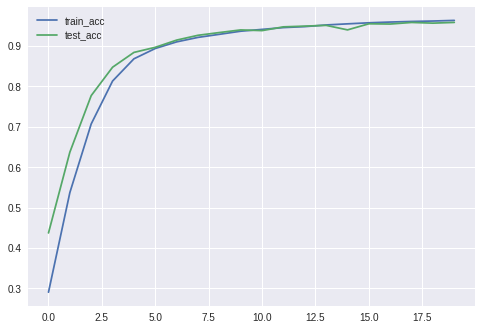

In [8]:
# Plot training and test accuracy
plt.style.use('seaborn')
plt.plot(hist_KDL.history['accuracy'], label='train_acc', color='C0')
plt.plot(hist_KDL.history['val_accuracy'], label='test_acc', color='C1')
plt.legend()

In [9]:
# Build the dense model
# input layer
i = Input(shape=x_train[0].shape)
x = Flatten()(i)
 
# Hidden layers
x = Dense(784, activation='tanh')(x)

x = Dense(784, activation='tanh')(x)
 
x = Dense(10, activation='softmax')(x)

# Build the model
model = Model(i, x)
 
# model summary
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 784)               615440    
                                                                 
 dense_1 (Dense)             (None, 784)               615440    
                                                                 
 dense_2 (Dense)             (None, 10)                7850      
                                                                 
Total params: 1,238,730
Trainable params: 1,238,730
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Compile
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-2),
              loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [11]:
hist_dense = model.fit(
  x_train, y_train, batch_size=128, validation_data=(x_test, y_test), epochs=20)

Epoch 1/20
469/469 [==============================] - 13s 27ms/step - loss: 0.7528 - accuracy: 0.8220 - val_loss: 0.4371 - val_accuracy: 0.8848
Epoch 2/20
469/469 [==============================] - 12s 26ms/step - loss: 0.4088 - accuracy: 0.8883 - val_loss: 0.3573 - val_accuracy: 0.9021
Epoch 3/20
469/469 [==============================] - 13s 27ms/step - loss: 0.3572 - accuracy: 0.8993 - val_loss: 0.3271 - val_accuracy: 0.9085
Epoch 4/20
469/469 [==============================] - 13s 27ms/step - loss: 0.3320 - accuracy: 0.9058 - val_loss: 0.3105 - val_accuracy: 0.9144
Epoch 5/20
469/469 [==============================] - 14s 29ms/step - loss: 0.3161 - accuracy: 0.9101 - val_loss: 0.2991 - val_accuracy: 0.9140
Epoch 6/20
469/469 [==============================] - 12s 26ms/step - loss: 0.3046 - accuracy: 0.9130 - val_loss: 0.2890 - val_accuracy: 0.9173
Epoch 7/20
469/469 [==============================] - 13s 28ms/step - loss: 0.2956 - accuracy: 0.9160 - val_loss: 0.2823 - val_accuracy:

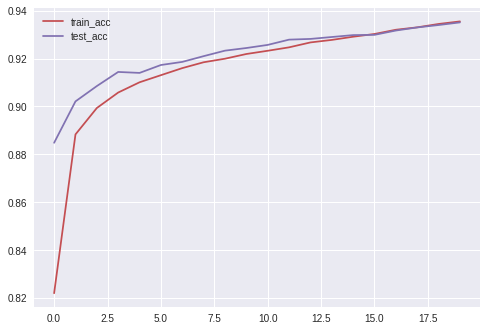

In [12]:
# Plot training and test accuracy
plt.plot(hist_dense.history['accuracy'], label='train_acc', color='C2')
plt.plot(hist_dense.history['val_accuracy'], label='test_acc', color='C3')
plt.legend()

In [13]:
# Build a KDL model with Kronecker rank 2
# input layer
i = Input(shape=x_train[0].shape)

# Hidden layer pairs
x1 = KDLeftLayer(28, activation='tanh')(i)
x1 = KDRightLayer(28)(x1)

x2 = KDLeftLayer(28, activation='tanh')(i)
x2 = KDRightLayer(28)(x2)

# Combine Result
x = Add()([x1,x2])
x = Activation('tanh')(x)

# Another set of layer pairs
x1 = KDLeftLayer(28, activation='tanh')(x)
x1 = KDRightLayer(28)(x1)

x2 = KDLeftLayer(28, activation='tanh')(x)
x2 = KDRightLayer(28)(x2)

x = Add()([x1,x2])
x = Activation('tanh')(x)

# Final set of Layer pairs
x1 = KDLeftLayer(2, activation='tanh')(x)
x1 = KDRightLayer(5)(x1)

x2 = KDLeftLayer(2, activation='tanh')(x)
x2 = KDRightLayer(5)(x2)

x = Add()([x1,x2])

# Reshape for output
x = Reshape((10,))(x)
x = Softmax()(x)
model = Model(i, x)
 
# model summary
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 28, 28)]     0           []                               
                                                                                                  
 kd_left_layer_3 (KDLeftLayer)  (None, 28, 28)       1568        ['input_3[0][0]']                
                                                                                                  
 kd_left_layer_4 (KDLeftLayer)  (None, 28, 28)       1568        ['input_3[0][0]']                
                                                                                                  
 kd_right_layer_3 (KDRightLayer  (None, 28, 28)      1568        ['kd_left_layer_3[0][0]']        
 )                                                                                          

In [14]:
# Compile
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=5e-2),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
hist_KDL2 = model.fit(
  x_train, y_train, batch_size=128, validation_data=(x_test, y_test), epochs=20)

Epoch 1/20
469/469 [==============================] - 14s 26ms/step - loss: 1.3761 - accuracy: 0.5860 - val_loss: 0.5058 - val_accuracy: 0.8485
Epoch 2/20
469/469 [==============================] - 12s 25ms/step - loss: 0.4314 - accuracy: 0.8734 - val_loss: 0.3481 - val_accuracy: 0.8989
Epoch 3/20
469/469 [==============================] - 12s 25ms/step - loss: 0.3316 - accuracy: 0.9040 - val_loss: 0.2843 - val_accuracy: 0.9189
Epoch 4/20
469/469 [==============================] - 12s 26ms/step - loss: 0.2779 - accuracy: 0.9182 - val_loss: 0.2424 - val_accuracy: 0.9303
Epoch 5/20
469/469 [==============================] - 12s 25ms/step - loss: 0.2423 - accuracy: 0.9286 - val_loss: 0.2140 - val_accuracy: 0.9393
Epoch 6/20
469/469 [==============================] - 12s 26ms/step - loss: 0.2178 - accuracy: 0.9355 - val_loss: 0.1978 - val_accuracy: 0.9431
Epoch 7/20
469/469 [==============================] - 12s 25ms/step - loss: 0.1987 - accuracy: 0.9415 - val_loss: 0.1822 - val_accuracy:

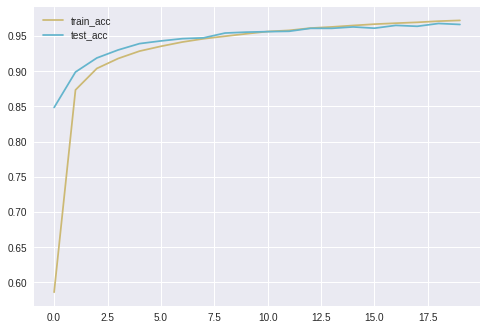

In [16]:
# Plot training and test accuracy
plt.plot(hist_KDL2.history['accuracy'], label='train_acc', color='C4')
plt.plot(hist_KDL2.history['val_accuracy'], label='test_acc', color='C5')
plt.legend()

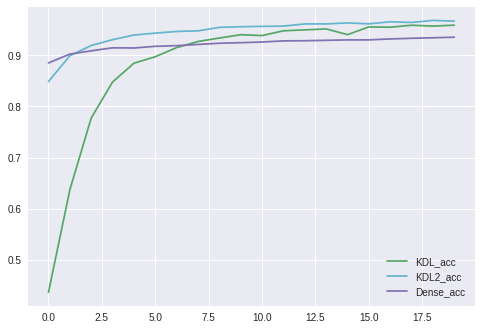

In [17]:
# Plot test accuracy comparison
plt.plot(hist_KDL.history['val_accuracy'], label='KDL_acc', color='C1')
plt.plot(hist_KDL2.history['val_accuracy'], label='KDL2_acc', color='C5')
plt.plot(hist_dense.history['val_accuracy'], label='Dense_acc', color='C3')
plt.legend()